<a href="https://colab.research.google.com/github/amcwong/FizzBuzz/blob/main/bcb330_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Set up

from google.colab import drive
drive.mount('/content/drive')

# !pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117
!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu118

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu118
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 22.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 89.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 37.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjit

In [ ]:
# Defining Paths
# !nvcc --version

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


base_dir = '/content/drive/My Drive/Electrophysiology_Project'

# segments_dir = os.path.join(base_dir, 'segments_20241129_233026')
segments_dir = os.path.join(base_dir, 'segments_20250225_180439')


# Paths to training, validation, and test sets
train_segments_path = os.path.join(segments_dir, 'train', 'train_segments.npy')
train_metadata_path = os.path.join(segments_dir, 'train', 'train_metadata.csv')

val_segments_path = os.path.join(segments_dir, 'val', 'val_segments.npy')
val_metadata_path = os.path.join(segments_dir, 'val', 'val_metadata.csv')

test_segments_path = os.path.join(segments_dir, 'test', 'test_segments.npy')
test_metadata_path = os.path.join(segments_dir, 'test', 'test_metadata.csv')


In [ ]:
# Loading the data
X_train = np.load(train_segments_path)
y_train = pd.read_csv(train_metadata_path)['Label'].values

X_val = np.load(val_segments_path)
y_val = pd.read_csv(val_metadata_path)['Label'].values

X_test = np.load(test_segments_path)
y_test = pd.read_csv(test_metadata_path)['Label'].values

# Verifying shapes
print(f"Training set: {X_train.shape}, Validation set: {X_val.shape}, Test set: {X_test.shape}")


Training set: (86319, 540), Validation set: (18498, 540), Test set: (18498, 540)


In [ ]:
# Defining Dataset Class and Model
#
# This script sets up a PyTorch dataset and defines a 1D Convolutional Neural Network (CNN)
# for binary classification of electrophysiological signal segments into event and non-event categories.
#
# **Key Components:**
# 1. **SignalDataset Class:**
#    - Inherits from PyTorch's Dataset class to handle loading of signal segments and their corresponding labels.
#    - **Adding a Channel Dimension:** The `__getitem__` method adds an extra dimension to each segment to represent the channel,
#      transforming the data shape from (sequence_length,) to (1, sequence_length). This is essential for the CNN's
#      convolutional layers which expect input with channel information.
#
# 2. **CNN1D Model Class:**
#    - Defines a sequential 1D CNN architecture tailored for processing time-series data.
#    - **Convolutional Layers:** Three convolutional layers with increasing filter sizes capture hierarchical features
#      from the input signals.
#    - **Batch Normalization:** Applied after each convolution to stabilize and accelerate training by normalizing
#      layer inputs.
#    - **Pooling Layers:** Max pooling with a kernel size of 2 reduces the temporal dimension, retaining the most
#      significant features and reducing computational load. However, given that events are 2-5 ms (40-100 samples)
#      at a 20 kHz sampling rate, aggressive pooling (3 layers) may lead to loss of temporal resolution, making it
#      challenging to accurately detect short-duration events. Consider reducing the number of pooling layers or
#      adjusting the pooling strategy to better preserve event characteristics.
#    - **Flattening:** The output from the convolutional layers is flattened into a one-dimensional vector to interface
#      with the fully connected layers.
#    - **Fully Connected Layers:** A dense layer with ReLU activation followed by a dropout layer helps in learning
#      complex patterns and preventing overfitting. The final dense layer with sigmoid activation outputs probabilities
#      for binary classification.
#
# **Architectural Decisions:**
# - **Channel Dimension Addition:** Ensures compatibility with CNN layers by providing necessary channel information.
# - **Max Pooling:** Efficiently downsamples the data, capturing essential features while maintaining computational efficiency.
#   However, with events of 2-5 ms, pooling may reduce the ability to detect these events accurately.
# - **Flattening Before Dense Layers:** Converts multi-dimensional feature maps into a format suitable for classification layers.
# - **Dropout Layer:** Regularizes the model to enhance generalization and prevent overfitting, especially important in
#   datasets with class imbalance.


import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

class SignalDataset(Dataset):
    def __init__(self, segments, labels):
        self.segments = torch.tensor(segments, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __len__(self):
        return len(self.segments)
    def __getitem__(self, idx):
        # Added a channel dimension for CNN (channels=1)
        return self.segments[idx].unsqueeze(0), self.labels[idx]

class CNN1D(nn.Module):
    def __init__(self, input_length, dropout_rate=0.5, num_conv1=32, num_conv2=64, kernel_size=3):
        super(CNN1D, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_conv1, kernel_size=kernel_size, padding=1)
        self.bn1 = nn.BatchNorm1d(num_conv1)
        self.pool1 = nn.MaxPool1d(kernel_size=2)

        self.conv2 = nn.Conv1d(num_conv1, num_conv2, kernel_size=kernel_size, padding=1)
        self.bn2 = nn.BatchNorm1d(num_conv2)
        self.pool2 = nn.MaxPool1d(kernel_size=2)

        # Calculate the length after two pooling layers
        self.pool_output_length = input_length // 4  # Assuming kernel_size=2 for pooling

        self.fc1 = nn.Linear(num_conv2 * self.pool_output_length, 64)
        self.dropout = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(64, 1)  # Binary classification

    def forward(self, x):
        # x shape: (batch_size, 1, window_size)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x


In [ ]:
train_dataset = SignalDataset(X_train, y_train)
val_dataset = SignalDataset(X_val, y_val)
test_dataset = SignalDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)


In [ ]:
# Preparation for Training and Validation Loops

# GPU check
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Initialize model
input_length = X_train.shape[1]  # e.g., 1400
model = CNN1D(input_length=input_length).to(device)

# Define loss and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)



Using device: cuda


In [ ]:
# Define Training and Validation Loops:
# - Iterate over a set number of epochs to train the CNN.
# - **Training Phase**:
#     - Set the model to training mode.
#     - Loop through batches from the training DataLoader:
#         - Move data to the appropriate device (CPU/GPU).
#         - Perform forward pass, compute loss, perform backward pass, and update model weights.
#         - Accumulate training loss and correct predictions for accuracy.
# - **Validation Phase**:
#     - Set the model to evaluation mode.
#     - Loop through batches from the validation DataLoader without gradient computation:
#         - Perform forward pass and compute loss.
#         - Accumulate validation loss and correct predictions for accuracy.
# - **Logging and Early Stopping**:
#     - Record and print training and validation metrics each epoch.
#     - Save the model if validation loss improves.
#     - Stop training early if no improvement is seen for a specified number of epochs (patience).


# Training parameters:
# - num_epochs: Total number of training iterations over the dataset.
# - patience: Number of epochs to wait for validation loss improvement before stopping (early stopping).
# - best_val_loss: Tracks the lowest validation loss seen so far.
# - trigger_times: Counts epochs without improvement to enforce early stopping.

num_epochs = 50
patience = 5
best_val_loss = float('inf')
trigger_times = 0

# History for plotting
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

# Training loop
for epoch in range(1, num_epochs + 1):
    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        preds = (outputs > 0.5).float()
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs = inputs.to(device)
            labels = labels.to(device).unsqueeze(1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * inputs.size(0)
            preds = (outputs > 0.5).float()
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

    val_epoch_loss = val_running_loss / val_total
    val_epoch_acc = val_correct / val_total

    # History saving
    history['train_loss'].append(epoch_loss)
    history['train_acc'].append(epoch_acc)
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f'Epoch {epoch}/{num_epochs} - '
          f'Train Loss: {epoch_loss:.4f} - Train Acc: {epoch_acc:.4f} - '
          f'Val Loss: {val_epoch_loss:.4f} - Val Acc: {val_epoch_acc:.4f}')

    # Early Stopping
    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        trigger_times = 0
        # Save the best model
        torch.save(model.state_dict(), os.path.join(base_dir, 'models', 'saved_models', 'best_model.pth'))
        print(f'Validation loss decreased. Saving model.')
    else:
        trigger_times += 1
        print(f'No improvement in validation loss for {trigger_times} epoch(s).')
        if trigger_times >= patience:
            print('Early stopping!')
            break


Epoch 1/50 - Train Loss: 0.2411 - Train Acc: 0.9156 - Val Loss: 0.1821 - Val Acc: 0.9337
Validation loss decreased. Saving model.
Epoch 2/50 - Train Loss: 0.2141 - Train Acc: 0.9276 - Val Loss: 0.2153 - Val Acc: 0.9217
No improvement in validation loss for 1 epoch(s).
Epoch 3/50 - Train Loss: 0.2070 - Train Acc: 0.9297 - Val Loss: 0.1709 - Val Acc: 0.9356
Validation loss decreased. Saving model.
Epoch 4/50 - Train Loss: 0.1996 - Train Acc: 0.9333 - Val Loss: 0.1790 - Val Acc: 0.9402
No improvement in validation loss for 1 epoch(s).
Epoch 5/50 - Train Loss: 0.1914 - Train Acc: 0.9352 - Val Loss: 0.1755 - Val Acc: 0.9387
No improvement in validation loss for 2 epoch(s).
Epoch 6/50 - Train Loss: 0.1884 - Train Acc: 0.9367 - Val Loss: 0.1629 - Val Acc: 0.9421
Validation loss decreased. Saving model.
Epoch 7/50 - Train Loss: 0.1787 - Train Acc: 0.9392 - Val Loss: 0.1601 - Val Acc: 0.9431
Validation loss decreased. Saving model.
Epoch 8/50 - Train Loss: 0.1741 - Train Acc: 0.9406 - Val Loss:

<ipython-input-8-e311d7b7dc0a>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(os.path.join(base_dir, 'models', 'saved_models', 'best_mode


Classification Report:
              precision    recall  f1-score   support

   Non-Event       0.96      0.96      0.96     12332
       Event       0.92      0.92      0.92      6166

    accuracy                           0.95     18498
   macro avg       0.94      0.94      0.94     18498
weighted avg       0.95      0.95      0.95     18498



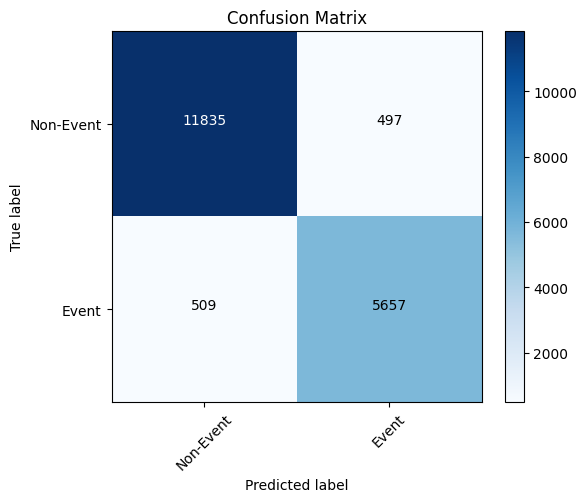

Final model saved to /content/drive/My Drive/Electrophysiology_Project/models/saved_models/final_model.pth


In [ ]:
# Evaluate on Test Set:
# - Load the best saved model and switch to evaluation mode.
# - Generate predictions for the test dataset.
# - Compute and display classification metrics (precision, recall, F1-score).
# - Create and save a confusion matrix to visualize performance.
# - Save the final trained model for future use.


# Load the best model
model.load_state_dict(torch.load(os.path.join(base_dir, 'models', 'saved_models', 'best_model.pth')))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device).unsqueeze(1)

        outputs = model(inputs)
        preds = (outputs > 0.5).float()

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Classification Report
from sklearn.metrics import classification_report, confusion_matrix

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=['Non-Event', 'Event']))

# Confusion Matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Non-Event', 'Event'], rotation=45)
plt.yticks(tick_marks, ['Non-Event', 'Event'])

fmt = 'd'
thresh = cm.max() / 2.
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], fmt),
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.tight_layout()
plt.savefig(os.path.join(base_dir, 'models', 'saved_models', 'confusion_matrix.png'))
plt.show()

# Save the final model
torch.save(model.state_dict(), os.path.join(base_dir, 'models', 'saved_models', 'final_model.pth'))
print(f"Final model saved to {os.path.join(base_dir, 'models', 'saved_models', 'final_model.pth')}")

In [ ]:
# Output classification metadata in separate folders -----

# Reload the full test metadata (which includes additional information beyond the labels)
test_metadata_df = pd.read_csv(test_metadata_path)
# Add a new column for the predictions (make sure the order of rows in the CSV matches the order used in testing)
test_metadata_df['Prediction'] = all_preds

# Define classification outcomes
true_positives  = test_metadata_df[(test_metadata_df['Label'] == 1) & (test_metadata_df['Prediction'] == 1)]
true_negatives  = test_metadata_df[(test_metadata_df['Label'] == 0) & (test_metadata_df['Prediction'] == 0)]
false_positives = test_metadata_df[(test_metadata_df['Label'] == 0) & (test_metadata_df['Prediction'] == 1)]
false_negatives = test_metadata_df[(test_metadata_df['Label'] == 1) & (test_metadata_df['Prediction'] == 0)]

# Create a base folder for classification metadata
classification_metadata_dir = os.path.join(base_dir, 'classification_metadata')
os.makedirs(classification_metadata_dir, exist_ok=True)

# Create subfolders for each classification category
tp_dir = os.path.join(classification_metadata_dir, 'true_positives')
tn_dir = os.path.join(classification_metadata_dir, 'true_negatives')
fp_dir = os.path.join(classification_metadata_dir, 'false_positives')
fn_dir = os.path.join(classification_metadata_dir, 'false_negatives')

os.makedirs(tp_dir, exist_ok=True)
os.makedirs(tn_dir, exist_ok=True)
os.makedirs(fp_dir, exist_ok=True)
os.makedirs(fn_dir, exist_ok=True)

# Save the corresponding metadata CSV files into each folder
true_positives.to_csv(os.path.join(tp_dir, 'metadata.csv'), index=False)
true_negatives.to_csv(os.path.join(tn_dir, 'metadata.csv'), index=False)
false_positives.to_csv(os.path.join(fp_dir, 'metadata.csv'), index=False)
false_negatives.to_csv(os.path.join(fn_dir, 'metadata.csv'), index=False)

print("Saved classification metadata into separate folders for true positives, true negatives, false positives, and false negatives.")

Saved classification metadata into separate folders for true positives, true negatives, false positives, and false negatives.
